In [1]:
# Basics: https://en.wikipedia.org/wiki/Elementary_effects_method

# Sensitivity Analysis Examples: http://www.daetools.com/docs/tutorials-sa.html
# SALab: https://github.com/SALib/SALib

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

In [3]:
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}
problem



{'num_vars': 3,
 'names': ['x1', 'x2', 'x3'],
 'bounds': [[-3.141592653589793, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793]]}

In [4]:
# Generate samples
param_values = saltelli.sample(problem, 1000)
param_values.shape

(8000, 3)

In [5]:
# Run model (example)
Y = Ishigami.evaluate(param_values)
Y.shape

(8000,)

In [6]:
# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.060112 0.560137 0.089964
x2 0.447767 0.057053 0.438722 0.042664
x3 -0.004255 0.055425 0.242845 0.029605

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.089247
x1 x3 0.251526 0.111786
x2 x3 -0.009954 0.077167


### Morris Method

In [7]:
# https://github.com/SALib/SALib/blob/master/examples/morris/morris.py

import sys

from SALib.analyze import morris
from SALib.sample.morris import sample
from SALib.test_functions import Sobol_G
from SALib.util import read_param_file
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms
import matplotlib.pyplot as plt

In [8]:
# sys.path.append('../..')

# # Read the parameter range file and generate samples
# problem = read_param_file('../../src/SALib/test_functions/params/Sobol_G.txt')
# # or define manually without a parameter file:
problem = {
 'num_vars': 8,
 'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
 'groups': None,
 'bounds': [[0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0]]
}
# Files with a 4th column for "group name" will be detected automatically, e.g.
# param_file = '../../src/SALib/test_functions/params/Ishigami_groups.txt'
problem

{'num_vars': 8,
 'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
 'groups': None,
 'bounds': [[0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0]]}

In [93]:
# Generate samples
param_values = sample(problem, N=1000, num_levels=4,
                      optimal_trajectories=None)
param_values.shape
# To use optimized trajectories (brute force method),
# give an integer value for optimal_trajectories

(9000, 8)

In [10]:
# Run the "model" -- this will happen offline for external models
Y = Sobol_G.evaluate(param_values)
Y.shape

(9000,)

In [22]:
# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
Si = morris.analyze(problem, param_values, Y, conf_level=0.95,
                    print_to_console=True,
                    num_levels=4, num_resamples=100)
# Returns a dictionary with keys 'mu', 'mu_star', 'sigma', and 'mu_star_conf'
# e.g. Si['mu_star'] contains the mu* value for each parameter, in the
# same order as the parameter file

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  2.605     -0.000           0.047      2.733
x2                                  1.474      0.032           0.050      1.663
x3                                  0.595      0.029           0.020      0.696
x4                                  0.333     -0.013           0.014      0.388
x5                                  0.034      0.001           0.001      0.040
x6                                  0.035      0.002           0.001      0.041
x7                                  0.035      0.001           0.001      0.041
x8                                  0.034     -0.001           0.001      0.040


In [41]:
#Si

In [189]:
def covariance_plot(ax, Si, param_dict, unit="", annot=True):
    '''
    Plots mu* against sigma or the 95% confidence interval
    Modified by Nikhil to annotate the covariance plot with the parameter name
    '''

    if Si['sigma'] is not None:
        # sigma is not present if using morris groups
        y = Si['sigma']
        out = ax.scatter(Si['mu_star'], y, c=u'k', marker=u'o',
                         **param_dict)
        
        if annot is True:
            for i, txt in enumerate(Si['names']):
                ax.annotate(txt,
                            xy = (Si['mu_star'][i], y[i]),
                            xytext=(np.random.randint(-50,50),np.random.randint(-50,50)), 
                            textcoords='offset points', ha='center', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red')                    
                           )
            
        ax.set_ylabel(r'$\sigma$')

        ax.set_xlim(0,)
        ax.set_ylim(0,)

        x_axis_bounds = np.array(ax.get_xlim())

        line1, = ax.plot(x_axis_bounds, x_axis_bounds, 'k-')
        line2, = ax.plot(x_axis_bounds, 0.5 * x_axis_bounds, 'k--')
        line3, = ax.plot(x_axis_bounds, 0.1 * x_axis_bounds, 'k-.')

        ax.legend((line1, line2, line3), (r'$\sigma / \mu^{\star} = 1.0$',
                                          r'$\sigma / \mu^{\star} = 0.5$',
                                          r'$\sigma / \mu^{\star} = 0.1$'),
                  loc='best')

    else:
        y = Si['mu_star_conf']
        out = ax.scatter(Si['mu_star'], y, c=u'k', marker=u'o',
                         **param_dict)
        ax.set_ylabel(r'$95\% CI$')

    ax.set_xlabel(r'$\mu^\star$ ' + unit)
    ax.set_ylim(0-(0.01 * np.array(ax.get_ylim()[1])), )

    return out

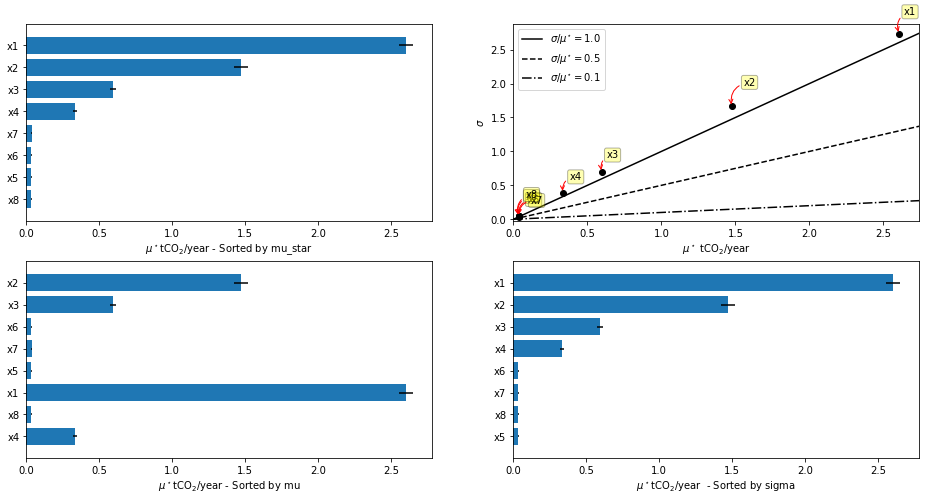

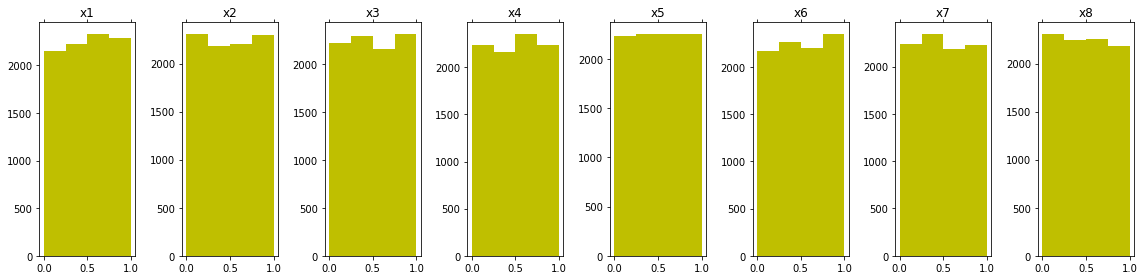

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
horizontal_bar_plot(axes[0,0], Si, {}, sortby='mu_star', unit=r"tCO$_2$/year - Sorted by mu_star")
covariance_plot(axes[0,1], Si, {}, unit=r"tCO$_2$/year")
horizontal_bar_plot(axes[1,0], Si, {}, sortby='mu', unit=r"tCO$_2$/year - Sorted by mu")
horizontal_bar_plot(axes[1,1], Si, {}, sortby='sigma', unit=r"tCO$_2$/year  - Sorted by sigma")


fig2 = plt.figure(figsize=(16,4))
sample_histograms(fig2, param_values, problem, {'color': 'y'})

plt.tight_layout()

### For PDK info

In [50]:
import pandas as pd

In [54]:
params = pd.read_csv("C:/Users/a0866893/TI Drive/DataAnalytics/iipp/pdk/lbc9/discrete/nmos/NCH_3V3_109/data/params.csv")
results = pd.read_csv("C:/Users/a0866893/TI Drive/DataAnalytics/iipp/pdk/lbc9/discrete/nmos/NCH_3V3_109/data/results.csv")

In [55]:
print(params.shape)
print(results.shape)

(10000, 21)
(10000, 19)


In [58]:
param_names = params.columns
result_names = results.columns
print(param_names)
print(result_names)

Index(['DatasetName', 'JobName', 'CornerName', 'harmony__temp', 'p_length',
       'p_vbs', 'p_vds', 'p_vgs', 'p_width', 'LINT1_LBC9_snd', 'NCH_LBC9_snd',
       'RSD_LBC9_snd', 'TOX_5V_LBC9_snd', 'WINT_LBC9_snd', 'nVFB_LBC9_snd',
       'NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm',
       'top_I0.MN0.MN9999.NCH_LBC9_mm', 'top_I0.MN0.MN9999.U0_LBC9_mm',
       'top_I0.MN0.MN9999.nVFB_LBC9_mm'],
      dtype='object')
Index(['DatasetName', 'JobName', 'CornerName', 'NCH_3V3_109.op.cgg',
       'NCH_3V3_109.op.gds', 'NCH_3V3_109.op.gm', 'NCH_3V3_109.op.gmbs',
       'NCH_3V3_109.op.gmoverid', 'NCH_3V3_109.op.ids', 'NCH_3V3_109.op.idsmm',
       'NCH_3V3_109.op.idsrd', 'NCH_3V3_109.op.region', 'NCH_3V3_109.op.rsw',
       'NCH_3V3_109.op.vbs', 'NCH_3V3_109.op.vds', 'NCH_3V3_109.op.vdsat',
       'NCH_3V3_109.op.vgs', 'NCH_3V3_109.op.vt', 'NCH_3V3_109.op.vtmm'],
      dtype='object')


In [75]:
join_on = ['JobName', 'DatasetName', 'CornerName']
data = pd.merge(params, results, how = "inner", on = join_on)
data.shape

(10000, 37)

In [76]:
data.columns

Index(['DatasetName', 'JobName', 'CornerName', 'harmony__temp', 'p_length',
       'p_vbs', 'p_vds', 'p_vgs', 'p_width', 'LINT1_LBC9_snd', 'NCH_LBC9_snd',
       'RSD_LBC9_snd', 'TOX_5V_LBC9_snd', 'WINT_LBC9_snd', 'nVFB_LBC9_snd',
       'NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm',
       'top_I0.MN0.MN9999.NCH_LBC9_mm', 'top_I0.MN0.MN9999.U0_LBC9_mm',
       'top_I0.MN0.MN9999.nVFB_LBC9_mm', 'NCH_3V3_109.op.cgg',
       'NCH_3V3_109.op.gds', 'NCH_3V3_109.op.gm', 'NCH_3V3_109.op.gmbs',
       'NCH_3V3_109.op.gmoverid', 'NCH_3V3_109.op.ids', 'NCH_3V3_109.op.idsmm',
       'NCH_3V3_109.op.idsrd', 'NCH_3V3_109.op.region', 'NCH_3V3_109.op.rsw',
       'NCH_3V3_109.op.vbs', 'NCH_3V3_109.op.vds', 'NCH_3V3_109.op.vdsat',
       'NCH_3V3_109.op.vgs', 'NCH_3V3_109.op.vt', 'NCH_3V3_109.op.vtmm'],
      dtype='object')

In [77]:
data.drop(join_on, axis=1, inplace=True)

In [82]:
param_names

Index(['DatasetName', 'JobName', 'CornerName', 'harmony__temp', 'p_length',
       'p_vbs', 'p_vds', 'p_vgs', 'p_width', 'LINT1_LBC9_snd', 'NCH_LBC9_snd',
       'RSD_LBC9_snd', 'TOX_5V_LBC9_snd', 'WINT_LBC9_snd', 'nVFB_LBC9_snd',
       'NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm',
       'top_I0.MN0.MN9999.NCH_LBC9_mm', 'top_I0.MN0.MN9999.U0_LBC9_mm',
       'top_I0.MN0.MN9999.nVFB_LBC9_mm'],
      dtype='object')

In [90]:
param_names = np.intersect1d(param_names, data.columns)
result_names = np.intersect1d(result_names, data.columns)

In [91]:
param_names

array(['LINT1_LBC9_snd', 'NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm',
       'NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm', 'NCH_LBC9_snd',
       'RSD_LBC9_snd', 'TOX_5V_LBC9_snd', 'WINT_LBC9_snd',
       'harmony__temp', 'nVFB_LBC9_snd', 'p_length', 'p_vbs', 'p_vds',
       'p_vgs', 'p_width', 'top_I0.MN0.MN9999.NCH_LBC9_mm',
       'top_I0.MN0.MN9999.U0_LBC9_mm', 'top_I0.MN0.MN9999.nVFB_LBC9_mm'],
      dtype=object)

In [92]:
result_names

array(['NCH_3V3_109.op.cgg', 'NCH_3V3_109.op.gds', 'NCH_3V3_109.op.gm',
       'NCH_3V3_109.op.gmbs', 'NCH_3V3_109.op.gmoverid',
       'NCH_3V3_109.op.ids', 'NCH_3V3_109.op.idsmm',
       'NCH_3V3_109.op.idsrd', 'NCH_3V3_109.op.region',
       'NCH_3V3_109.op.rsw', 'NCH_3V3_109.op.vbs', 'NCH_3V3_109.op.vds',
       'NCH_3V3_109.op.vdsat', 'NCH_3V3_109.op.vgs', 'NCH_3V3_109.op.vt',
       'NCH_3V3_109.op.vtmm'], dtype=object)

In [111]:
min_param_values = data[param_names].min().values
max_param_values = data[param_names].max().values
bounds = list(zip(min_param_values, max_param_values))
num_vars = len(param_names)

In [125]:
problem = {
    'num_vars': num_vars,
    'names': list(param_names),
    'groups': None,
    'bounds': bounds
}
# Files with a 4th column for "group name" will be detected automatically, e.g.
# param_file = '../../src/SALib/test_functions/params/Ishigami_groups.txt'
problem

{'num_vars': 18,
 'names': ['LINT1_LBC9_snd',
  'NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm',
  'NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm',
  'NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm',
  'NCH_LBC9_snd',
  'RSD_LBC9_snd',
  'TOX_5V_LBC9_snd',
  'WINT_LBC9_snd',
  'harmony__temp',
  'nVFB_LBC9_snd',
  'p_length',
  'p_vbs',
  'p_vds',
  'p_vgs',
  'p_width',
  'top_I0.MN0.MN9999.NCH_LBC9_mm',
  'top_I0.MN0.MN9999.U0_LBC9_mm',
  'top_I0.MN0.MN9999.nVFB_LBC9_mm'],
 'groups': None,
 'bounds': [(-5.99872303, 5.99916697),
  (-5.99886847, 5.99767494),
  (-5.99967718, 5.99526215),
  (-5.99868727, 5.99991274),
  (-5.99675083, 5.99826193),
  (-5.99989891, 5.99884176),
  (-5.99918509, 5.99842358),
  (-5.99986315, 5.99777555),
  (-54.969409899999995, 199.986511),
  (-5.99995327, 5.99553251),
  (0.600297689, 24.9983044),
  (0.00101587246, 3.59900641),
  (0.000139187367, 3.59997845),
  (7.17169605e-05, 5.4997406),
  (1.00919449, 99.9929428),
  (-5.99886847, 5.99767494),
  (-5.99967718, 5.99526215),

In [136]:
data_sample = data.sample(n=9500,random_state=101)
data_sample.shape

(9500, 34)

In [201]:
param_values = data_sample[param_names].values
print(param_values.shape)
Y = data_sample['NCH_3V3_109.op.vt'].values

(9500, 18)


In [215]:
# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
Si = morris.analyze(problem, param_values, Y, conf_level=0.95,
                    print_to_console=True,
                    num_levels=75, num_resamples=100)  # num_levels changesd to 75 since Franzon's group used between 50 and 100
# Returns a dictionary with keys 'mu', 'mu_star', 'sigma', and 'mu_star_conf'
# e.g. Si['mu_star'] contains the mu* value for each parameter, in the
# same order as the parameter file

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
LINT1_LBC9_snd                      2.247     -0.188           0.154      2.758
NCH_3V3_109.top_I0.MN2.MN9999.NCH_LBC9_mm      2.025      0.053           0.120      2.523
NCH_3V3_109.top_I0.MN2.MN9999.U0_LBC9_mm      2.136      0.020           0.140      2.682
NCH_3V3_109.top_I0.MN2.MN9999.nVFB_LBC9_mm      2.131      0.028           0.142      2.673
NCH_LBC9_snd                        2.206      0.705           0.157      2.737
RSD_LBC9_snd                        2.209      0.086           0.150      2.785
TOX_5V_LBC9_snd                     2.605      1.596           0.166      2.776
WINT_LBC9_snd                       2.246      0.016           0.156      2.826
harmony__temp                       2.578     -1.798           0.169      2.616
nVFB_LBC9_snd                       2.535      1.631           0.174      2.738
p_length                            2.173     -0.154           0.157      2.693
p_vbs  

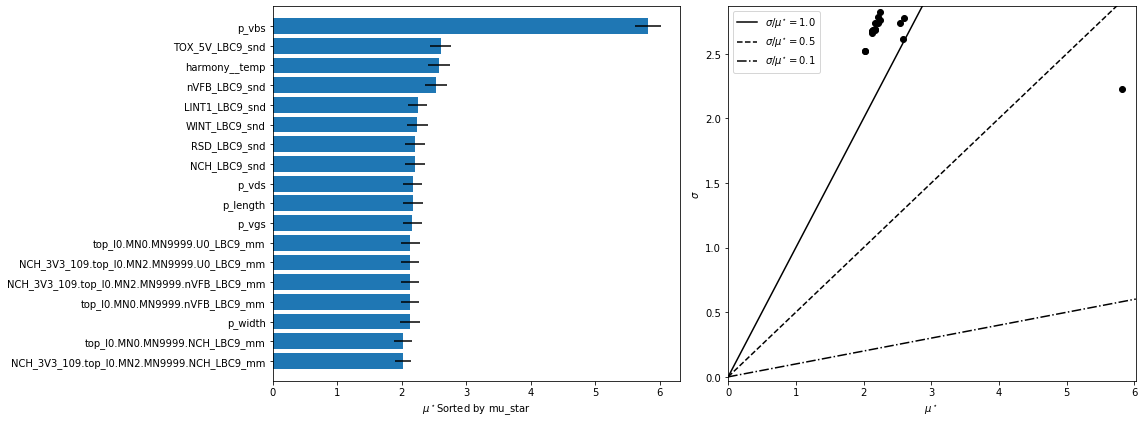

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
horizontal_bar_plot(axes[0], Si, {}, sortby='mu_star', unit=r"Sorted by mu_star")
covariance_plot(axes[1], Si, {}, unit=r"", annot=False)
plt.tight_layout()

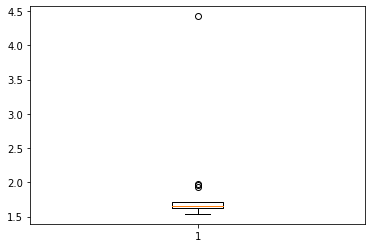

In [204]:
plt.boxplot(Si['mu_star'])
plt.show()